# Topic: Recommendation Systems
## Part 3: SOTA - BPR + Siamese CNN Network




## Imports

In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, MaxPooling2D, BatchNormalization, Conv2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Concatenate, Dot, Embedding
from datetime import datetime
from IPython.display import display
from io import StringIO, BytesIO
import requests
from pytz import timezone
from PIL import Image

# Get the Data

In [2]:
!wget http://cseweb.ucsd.edu/~wckang/DVBPR/AmazonFashion6ImgPartitioned.npy

--2022-12-06 20:53:04--  http://cseweb.ucsd.edu/~wckang/DVBPR/AmazonFashion6ImgPartitioned.npy
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~wckang/DVBPR/AmazonFashion6ImgPartitioned.npy [following]
--2022-12-06 20:53:04--  https://cseweb.ucsd.edu//~wckang/DVBPR/AmazonFashion6ImgPartitioned.npy
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3502475168 (3.3G)
Saving to: ‘AmazonFashion6ImgPartitioned.npy’

AmazonFashion6ImgPa 100%[===================>]   3.26G  11.0MB/s    in 3m 33s  

2022-12-06 20:56:38 (15.7 MB/s) - ‘AmazonFashion6ImgPartitioned.npy’ saved [3502475168/3502475168]



In [2]:
dataset = np.load("AmazonFashion6ImgPartitioned.npy", encoding="bytes",allow_pickle=True)
[user_train, user_validation, user_test, items, user_num, item_num] = dataset

newFile-9.jpg.avif
* _AmazonFashion_ (3.3GB): 64K users, 234K images, 0.5M actions

 
All datasets are stored in _.npy_ format, each item is associated with a JPG image. 
 

___Amazon Fashion Dataset___
* It consists of reviews of clothing items crawled from _Amazon.com_
* It contains six representative fashion categories (men/women’s tops, bottoms and shoes)
* We treat users’ reviews as ___implicit feedback___
* __For data preprocessing, inactive users _u_ (for whom $|I_u^+| < 5$) have been discarded. For each user, one action for validation and another for testing have been witheld randomly. All remaining items are used for training.__

Amazon datasets are derived from [here](http://jmcauley.ucsd.edu/data/amazon/)

## Initialization

In [3]:
IMAGE_SHAPE = (224,224)
K_dim = 50
decay = 0.001
lamb = 1.0
batch_size = 128

In [4]:
user_num_og = user_num
user_train_og = user_train 

#Ensure that each batch has the same number of user subsets
batch_count = int(np.ceil(user_num_og / batch_size))
user_subsets = dict(zip(range(batch_count), np.array_split(range(user_num_og), batch_count)))

## Utility Functions

We utilize the following repository for reimplementing the utility functions on top of the CNN network and BPR logic the proposed work defines:
https://github.com/amitdamri/Visually-Aware-Fashion-Recommendation-System

The following paper is reimplemented for the project:

https://arxiv.org/abs/1711.02231

https://cseweb.ucsd.edu/~wckang/slides_icdm17_public.pdf

In [5]:
def byte_to_np(image_bytes,shape):
    '''Converts image data in bytes to an np array'''
    img = (np.uint8(np.asarray(Image.open(BytesIO(image_bytes)).convert("RGB").resize(shape))) - 127.5)  / 127.5
    return img

In [6]:
def uniform_train_sample_batch(user_train_ratings, item_images, shape=(224,224), sample=True, batch_size=None, user_idx=None):
    '''Sample a training batch for user u where i is the item user prefers and j is the item the user has a negative interaction with'''

    if batch_size is not None:
        users = range(batch_size)
    else:
        users = user_idx

    triplet_train_batch = {}
    for b in users:
        if sample:
            u = random.randrange(len(user_train_ratings))
        else:
            u = b
            
        i = user_train_ratings[u][random.randrange(len(user_train_ratings[u]))][b'productid']
        j = random.randrange(len(item_images))
        
        # while the sampled items observed by the user - sample other item until found non-observed item
        while j in [item[b'productid'] for item in user_train_ratings[u]]:
            j = random.randrange(len(item_images))

        image_i = byte_to_np(item_images[i][b'imgs'], 
                                  shape)
        image_j = byte_to_np(item_images[j][b'imgs'],
                                  shape)
        triplet_train_batch[u] = [image_i,
                                  image_j]
        
    return triplet_train_batch

In [7]:
def uniform_validation_sample_batch(user_train_ratings, user_validation_ratings, item_images, shape=(224,224),
                                    validation_sample_count=1000, sample=True, batch_size=None, user_idx=None):
    '''Sample a validation batch for user u where i is the item user prefers and j is the item the user has a negative interaction with'''

    if batch_size is not None:
        users = range(batch_size)
    else:
        users = user_idx

    triplet_validation_batch = {}
    
    # For each user in subset 
    for b in users:
        if sample:
            u = random.randrange(len(user_train_ratings))
        else:
            u = b
        i = user_validation_ratings[u][0][b'productid']
        image_i = byte_to_np(item_images[i][b'imgs'], shape)

        #Check for all reviewed items 
        reviewed_items = set()
        for item in user_train_ratings[u]:
            reviewed_items.add(item[b'productid'])
        reviewed_items.add(user_validation_ratings[u][0][b'productid'])

        #Search for j and obtain image
        triplet_validation_batch[u] = []
        got = False
        for j in random.sample(range(len(item_images)), validation_sample_count):
            if j not in reviewed_items:
                image_j = byte_to_np(item_images[j][b'imgs'], shape)
                triplet_validation_batch[u] = [image_i, image_j]
                got = True
            
            if got:
              break

    return triplet_validation_batch

In [8]:
def get_train(user_subset, user_train):
    '''Get one training batch'''
    return uniform_train_sample_batch( sample=False, user_idx=user_subset, user_train_ratings=user_train,
        item_images=items,shape=IMAGE_SHAPE)
    
def get_validation(user_subset, user_train):
    '''Get one validation batch'''
    return uniform_validation_sample_batch(sample=False,user_idx=user_subset, user_train_ratings=user_train, 
        user_validation_ratings=user_validation,item_images=items,shape=IMAGE_SHAPE, validation_sample_count=100)

## BPR Function for getting triplets

In [9]:
def get_triplet_lists(train):
    '''Obtain train batch in the u, i, j, label format'''
    user_arr = []
    i_arr = []
    j_arr = []
    
    for u, triplet in train.items():
        user_arr.append(u)
        i_arr.append(triplet[0])
        j_arr.append(triplet[1])
        
    # create dummy label set 
    labels = np.ones((len(train), 1), dtype=int)
    
    return user_arr, i_arr, j_arr, labels

## Define Generator Functions

In [10]:
def train_generator():
    '''Defines train generator by using get_triplet_lists'''
    batches = range(batch_count)
    batch_per_epoch =0
    user_batch_id = 0
    user_subset_idx = 0
    while True:
        #get users in that particular batch and obtain triplet lists for train_set 
        user_subset = user_subsets[user_subset_idx] 
        user_train = {k: v for k, v in user_train_og.items() if k in user_subset}
        train = get_train(user_subset, user_train)
        user, i, j, labels = get_triplet_lists(train)
        
        yield [np.asarray(user), np.asarray(i), np.asarray(j)], np.asarray(labels)
        
        batch_per_epoch+=1
        user_batch_id+=1
        
        if batch_per_epoch >= batch_count:
            batch_per_epoch = 0
            user_batch_id = 0

def val_generator(mode='val'):
    '''Defines train generator by using get_triplet_lists'''
    user_subset_idx = 0
    u = None
    if mode=='val':
        u = user_validation
    elif mode=='test':
        u = user_test
        
    batches = range(batch_count)
    batch_per_epoch = 0
    user_batch_id = 0
    while True:
        user_subset = user_subsets[user_subset_idx] # get batch users
        validation = get_validation(user_subset, u)
        user, i, j, labels = get_triplet_lists(validation)
        yield [np.asarray(user), np.asarray(i), np.asarray(j)], np.asarray(labels)

        batch_per_epoch+=1
        user_batch_id+=1
        
        if batch_per_epoch >= batch_count:
            batch_per_epoch = 0
            user_batch_id = 0

## CNN Model Architecture 

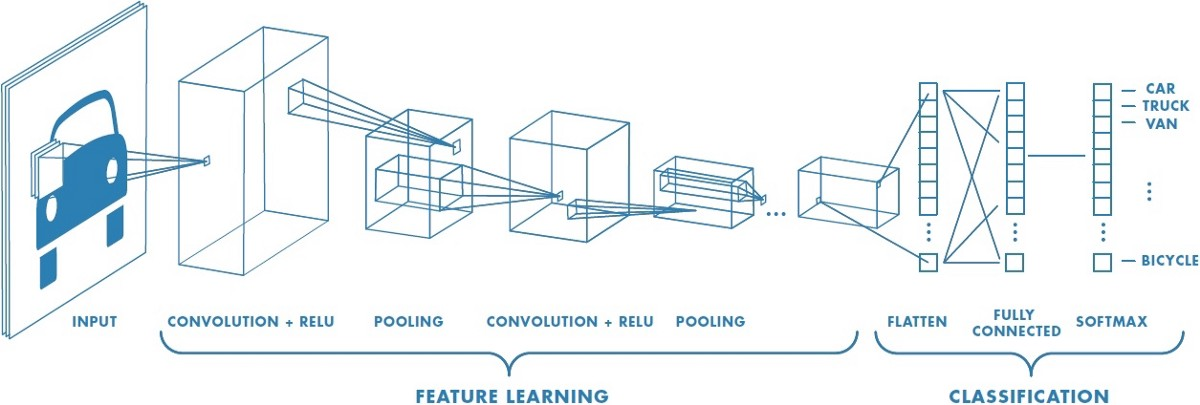

In [11]:
def CNN(shape, depth, K_dim, w_init=None, cnn_reg=None, fc_reg=None, b_init=None):
    ''' Build the CNN which off which we will base our siamese network'''
    model = Sequential()
    input_shape = (shape[0], shape[1], depth)
    channel_dim = -1
    
    #conv1
    model.add(Conv2D(64, (7, 7), strides = (2,2), padding="same", kernel_initializer=w_init,kernel_regularizer=cnn_reg,
                      bias_initializer=b_init, input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(padding="same"))

    #conv2
    model.add(Conv2D(128, (5, 5), padding="same", kernel_initializer=w_init,kernel_regularizer=cnn_reg,
                      bias_initializer=b_init, input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))

    #conv3 
    model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer=w_init,kernel_regularizer=cnn_reg,
                      bias_initializer=b_init, input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(padding="same"))


    #conv4 
    model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer=w_init,kernel_regularizer=cnn_reg,
                      bias_initializer=b_init, input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(padding="same"))

    model.add(Flatten())
    
    #fc1`
    model.add(Dense(4096, kernel_initializer=w_init, kernel_regularizer=fc_reg, bias_initializer=b_init))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    #fc2 
    model.add(Dense(2048, kernel_initializer=w_init, kernel_regularizer=fc_reg, bias_initializer=b_init))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    #output layer 
    model.add(Dense(K_dim, kernel_initializer=w_init, kernel_regularizer=fc_reg, bias_initializer=b_init))

    return model

## Siamese


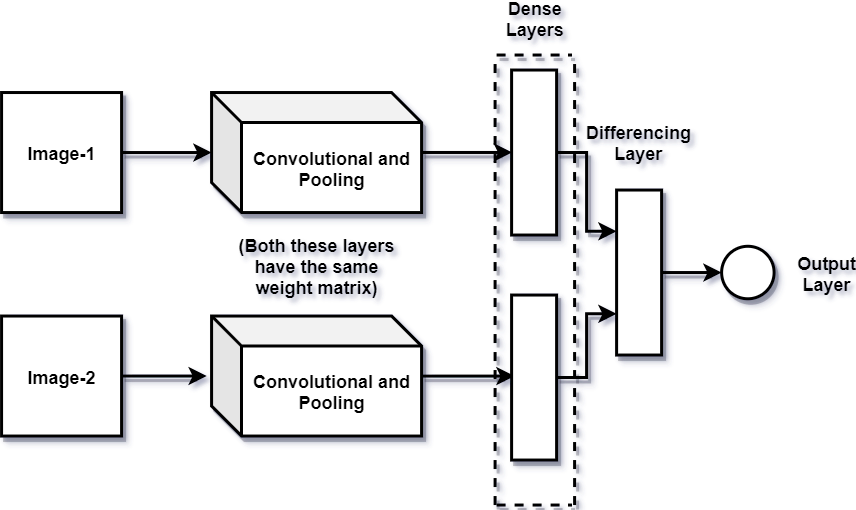

In [12]:
def ConvSiameseNet(users_dim, shape, depth,K_dim, w_init=None, cnn_reg=None, fc_reg=None, u_w_regularizer=None, b_init=None):
    '''Defines our siamese convolutional neural network that we use to compare our i and j item images'''
        
    #Define shapes for user and image
    user_input = Input((1,))
    image_shape = (shape[0], shape[1], depth)
        
    input_l = Input(image_shape)
    input_r = Input(image_shape)

    conv_net = CNN(shape, depth, K_dim, w_init, fc_reg, b_init)

    preference_relationship = Dot(axes=1)

    #use a single convolutional network to obtain encoded representations of i and j 
    encoded_l = conv_net(input_l)
    encoded_r = conv_net(input_r)

    #Get L1 distance using subtract layer 
    sub = tf.keras.layers.Subtract()([encoded_l, encoded_r])
        
    
    user_vec = Flatten()(Embedding(user_num+1, K_dim, embeddings_initializer= tf.keras.initializers.RandomUniform(0,0.01),
                                                          input_length=1, embeddings_regularizer=u_w_regularizer)(user_input))

    #compute dot product between samples in sub and user_vec 
    prediction = preference_relationship([user_vec, sub])
        
    model = Model(inputs=[user_input, input_l, input_r],
                      outputs=prediction)
        
    return model

In [13]:
def bpr_loss(label_matrix, prediction_matrix):
    '''Defines BPR objective i.e our log liklehiid funct'''
    return 1 - tf.reduce_sum(tf.math.log(tf.sigmoid(prediction_matrix)))

def auc(label_tensor, prediction_tensor):
    '''Calculate area under curve'''
    return K.mean(K.switch(prediction_tensor > K.zeros_like(prediction_tensor),
                           K.ones_like(prediction_tensor),   
                           K.zeros_like(prediction_tensor))) 


In [14]:
conv_siamese_net = ConvSiameseNet(users_dim=len(user_subsets[0]),
                                        shape=IMAGE_SHAPE,
                                        depth=3,
                                        K_dim=K_dim,
                                        cnn_reg=l2(decay),
                                        fc_reg=l2(decay),
                                        u_w_regularizer=l2(lamb),
                                        w_init = tf.keras.initializers.GlorotNormal())


#Set optimizer Adam with learning rate 9e-6
optimizer = Adam(9e-6)
conv_siamese_net.compile(loss=bpr_loss, optimizer=optimizer, metrics=[auc])

In [15]:
train_generator = train_generator()
validation_generator = val_generator(mode='val')

In [16]:
val = []
history = []

#Train the model for 5 epochs, validate after every 5 epochs 
for i in range(1):
  history.append(conv_siamese_net.fit(x=train_generator, steps_per_epoch = batch_count, epochs = 5)) # train
  val.append(conv_siamese_net.evaluate(validation_generator, steps = batch_count)) # validation
  print(val)

Epoch 1/5
353/353 [==============================] - 478s 1s/step - loss: 132.6359 - auc: 0.6037
Epoch 2/5
353/353 [==============================] - 469s 1s/step - loss: 70.5095 - auc: 0.8038
Epoch 3/5
353/353 [==============================] - 465s 1s/step - loss: 41.6756 - auc: 0.8780
Epoch 4/5
353/353 [==============================] - 465s 1s/step - loss: 28.0096 - auc: 0.9157
Epoch 5/5
353/353 [==============================] - 424s 1s/step - loss: 120.4864 - auc: 0.7119
[[120.48641204833984, 0.7119113206863403]]


In [17]:
test_gen = val_generator(mode='test')
conv_siamese_net.evaluate(test_gen, steps = batch_count)

353/353 [==============================] - 421s 1s/step - loss: 120.9952 - auc: 0.7112


[120.99517822265625, 0.7111809253692627]